# Objectives
YWBAT
* describe the difference between random, adaboost, and gradient boosted forests
* explain the pros and cons of each

# Outline
* understand that good data analysis and feature engineering cannot be beaten
* build pipelines to make your workflow better


# Questions
* Can machine learning predict outliers?
    * not well
    * there are techniques for outlier detection and anomaly detection

## Random Forest
* What is random in a random forest?
    * random samples the features it will use to build a decision tree
* How is bootstrap sampling used?
    * each tree is trained on a bootstrapped sample of the training data
    * bootstrap sampling is random
    * more independence b/w trees
        * you won't end up with the same tree
    * doesn't overfit
    * but the data will likely have less outlier influence
    * we get a mean class prediction that is closer to the ground truth
* How does it classify a point?
    * say you have 8 decision trees
        * 5 trees label 0, 3 trees label 1
        * the forest would choose 0 since 5/8 labeled 0.

<img src="./images/randomforest.jpg"/>

## Adaboost Forest 
* Algorithm:
    * Step 1: Split the training data into
        * InBag Samples: 70%
        * OutOfBag Samples: 30%
    * Step 2: Build a Decision Tree Stump on the InBag Sample
    * Step 3: Evaluate that tree on the OutOfBag Sample
        * If it gets a point correct → nothing happens
        * If it gets a point incorrect → that point will be in the InBag of the next sample
    * Step 4: Repeat Step 1
        * InBag Samples: 70% (but will contain all points that were mislabled)
        * OutOfBag Samples: 30%
    * Step 5: Builds a Decision Tree Stump on the new InBag Sample (weak-learner)
        * same processing for outofbag
    * Step 6: Repeat Steps 4-5 until num_trees is reached
* How does it classify a point?
    * say you have 8 decision trees
        * 5 trees label 0, 3 trees label 1
        * the forest would choose 0 since 5/8 labeled 0.
* does a weak learner also trian on the inbag sample-yes.
    * inbag sample (first tree) is a random 70%
    * inbag sample (after first tree) is a random % + all points that were mislabeled in previous outofbag totaling 70%
        * inbag = 70% total = X% of mislabeled points + (70-X)% of random points
* Cons
    * sensitive to outliers


<img src="./images/adaboost.png" width="50%"/>

## Gradient Boosting
* Builds a Decision Tree on training data
* Then builds decision trees based on the residuals from the previous tree
* Error will decrease as more trees are built
    * Error → 0
* The faster the residuals converge to 0, the better
<img src="./images/gradboost.png" width="50%"/>

In [5]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.tree import plot_tree

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly
import plotly.graph_objects as go

In [4]:
df = pd.read_csv("../data/bank-full.csv")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [6]:
df_train, df_validation = train_test_split(df, test_size=.10)

In [7]:
feature_to_use = ['age', 'balance', 'housing', 'loan']

In [15]:
X = df_train[feature_to_use]
y = df_train['y']

In [21]:
transformer = lambda x: 1 if x=="yes" else 0

In [25]:
def transform_df(df):
    df['housing'] = df['housing'].apply(transformer)
    df['loan'] = df['loan'].apply(transformer)
    return df

In [26]:
X = transform_df(X)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [28]:
X_train.shape, X_test.shape

((32551, 4), (8138, 4))

In [29]:
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(no     0.882922
 yes    0.117078
 Name: y, dtype: float64,
 no     0.882404
 yes    0.117596
 Name: y, dtype: float64)

In [30]:
smote = SMOTE()

In [31]:
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [45]:
# let's fit a random forest, betty crocker style
clf = RandomForestClassifier(n_estimators=10, max_depth=5)

In [46]:
clf.fit(X_train_smote, y_train_smote)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [47]:
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.6515007219440263, 0.6475792578028999)

In [48]:
df_validation = transform_df(df_validation)

In [49]:
X_valid = df_validation[feature_to_use]
y_valid = df_validation['y']

In [51]:
clf.score(X_valid, y_valid)

0.15833701901813357

## Let's plot a tree

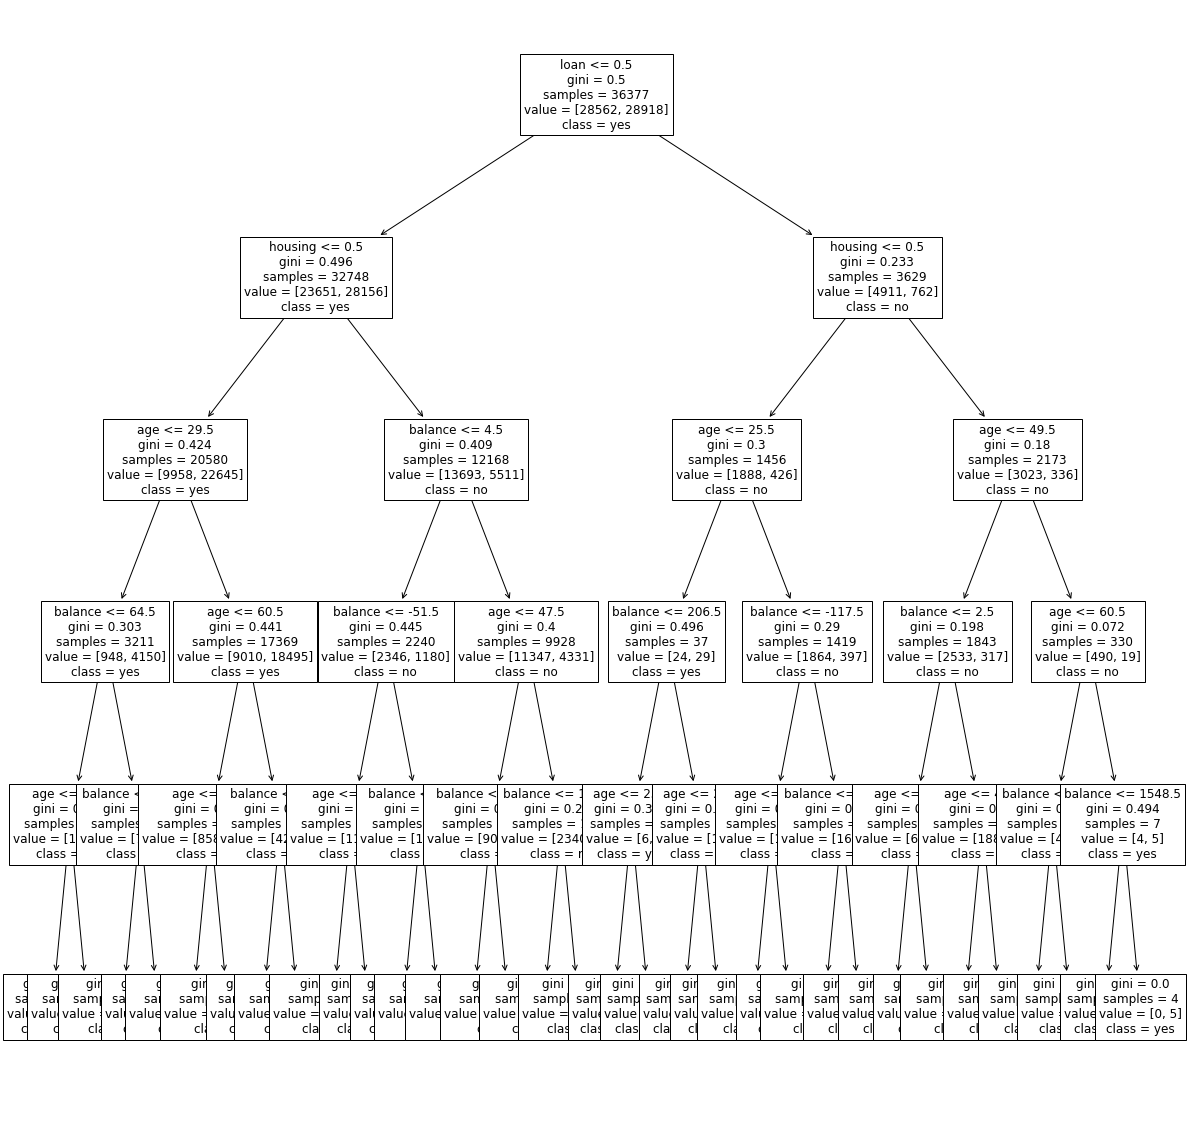

In [52]:
first_tree = clf.estimators_[0]
plt.figure(figsize=(20, 20))
plot_tree(first_tree, feature_names=X_train.columns, class_names=df['y'].unique(), fontsize=12)
plt.show()

In [54]:
# feature importance analysis
features = X.columns
feature_importance_scores = clf.feature_importances_

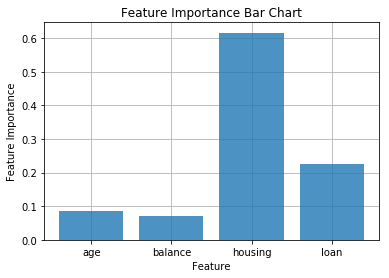

In [59]:
plt.bar(features, feature_importance_scores, zorder=2, alpha=0.8)
plt.grid(zorder=0)
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.title("Feature Importance Bar Chart")
plt.show()

## How do we know which features are the best? 

In [81]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif

In [82]:
selector = SelectKBest(score_func=f_classif, k=3)

In [83]:
X_all = df[feature_to_use]
y_all = df['y']

In [84]:
X_all = transform_df(X_all)

In [85]:
X_all.head()

,age,balance,housing,loan
0,58,2143,1,0
1,44,29,1,0
2,33,2,1,1
3,47,1506,1,0
4,33,1,0,0


In [86]:
selector.fit(X_all, y_all)

SelectKBest(k=3, score_func=<function f_classif at 0x1a44c17378>)

In [87]:
selector.scores_

array([ 28.62523309, 126.57227551, 892.95057646, 211.16739503])

In [88]:
X_all.columns

Index(['age', 'balance', 'housing', 'loan'], dtype='object')

# What did we learn? 
* feature importance
* that i don't need to keep writing axis=1
* the breakdown of what's happening during adaboost
* not to rank ensemble models but think about use cases
* don't neglect feature engineering
* selectKbest